In [1]:
count=0
df_str=[]
idx=-1
import csv
with open('/Users/marcberghouse/Machine-Learning-in-Hydrology/data/streamflow/usgs_stream_discharge', newline = '') as data:                                                                                          
    data_reader = csv.reader(data, delimiter='\t')
    for row in data_reader:
        count=count+1
        if count>2:
            if row[0]!='USGS':
                if "agency_cd" in row[0]:
                    for i in range(len(row)):
                        #Get index for discharge
                        if "00060_00003" in row[i]:
                            if "cd" not in row[i]:
                                idx=i
                        #Get index for Temp (mean)
                        if "00010_00003" in row[i]:
                            if "cd" not in row[i]:
                                idx_temp=i
# #                         #pH (med)
                        if "00400_00008" in row[i]:
                            if "cd" not in row[i]:
                                idx_ph=i
# #                         #Sediment Load (mean)
#                         if "80155_00003" in row[i]:
#                             if "cd" not in row[i]:
#                                 idx_sed=i
#                         #Get index for Specific Conductance (mean)
                        if "00095_00003" in row[i]:
                            if "cd" not in row[i]:
                                idx_cond=i
        if idx!=-1:
            try:
                if ("n" not in row[idx])&("_" not in row[idx]) :
                    df_str.append([row[1],row[2],row[idx]
                                   ,row[idx_temp],row[idx_cond]
                                   ,row[idx_ph]])
                                  #,row[idx_temp_max],row[idx_temp_min]])
            except: 
                continue
                #print ("error with indexing")
                #print(row,count)

import numpy as np
arr_final=np.array(df_str)
for i in range(len(arr_final)):
    date=arr_final[i,1]
    year=float(date[0:4])
    month=float(date[5:7])
    day=float(date[8:10])
    arr_final[i,1]=(year-1990)*365+month*30+day
    for j in range(6):
        try:
            arr_final[i][j]=float(arr_final[i][j])
        except:
            arr_final[i][j]=np.nan
            
#Drop Nans if you set the except value in the cell above to nan
import pandas as pd
df=pd.DataFrame(arr_final.astype(float),columns=['site_id','date','discharge','temp','conductivity','pH'])
df.dropna(how='any',inplace=True)
#There are some erroneous datapoints with pH>14. These need to be dropped.
df.drop(df.index[df.pH>14], inplace=True)
arr_final=np.array(df)
arr_final



array([[1.481500e+06, 6.141000e+03, 2.540000e+02, 1.560000e+01,
        2.590000e+02, 7.900000e+00],
       [1.481500e+06, 6.142000e+03, 2.390000e+02, 1.560000e+01,
        2.860000e+02, 8.000000e+00],
       [1.481500e+06, 6.143000e+03, 2.190000e+02, 1.660000e+01,
        2.960000e+02, 8.100000e+00],
       ...,
       [6.711565e+06, 1.130900e+04, 4.910000e+01, 4.500000e+00,
        1.140000e+03, 7.900000e+00],
       [6.711565e+06, 1.131000e+04, 4.880000e+01, 3.800000e+00,
        1.140000e+03, 7.900000e+00],
       [6.711565e+06, 1.131100e+04, 4.720000e+01, 3.700000e+00,
        1.150000e+03, 8.000000e+00]])

# Loop to Test Different Models and Predict Different Variables

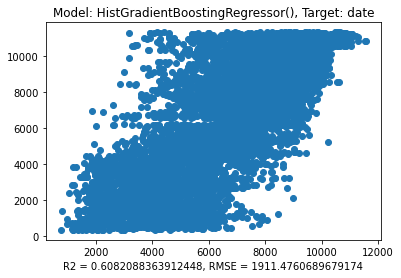

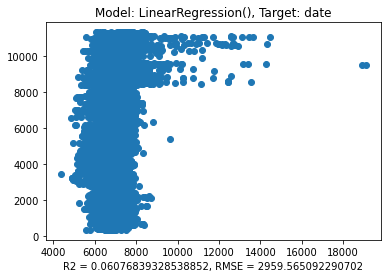

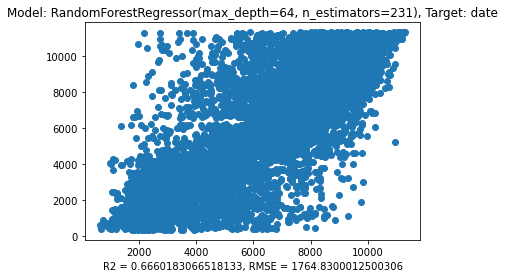

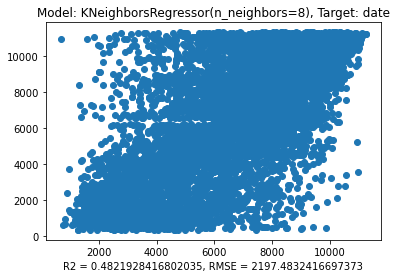

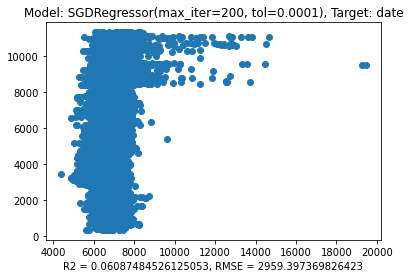

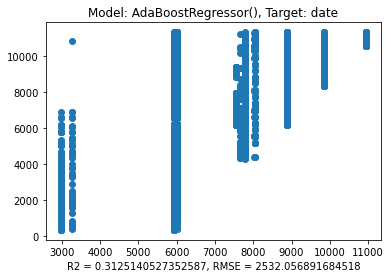

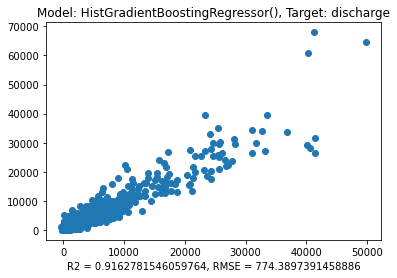

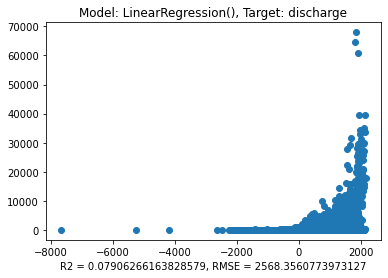

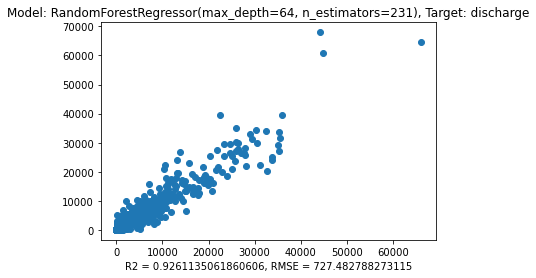

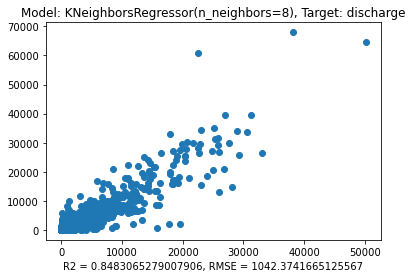

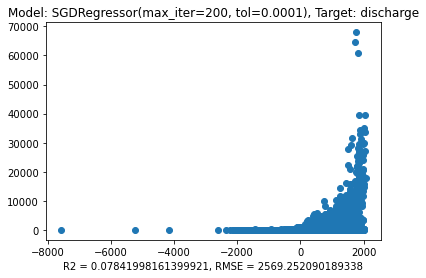

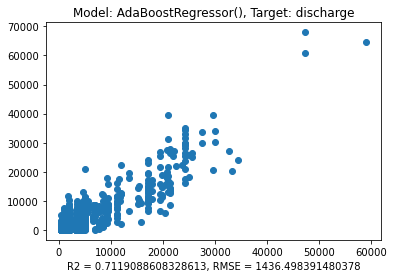

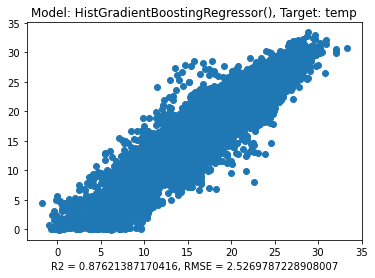

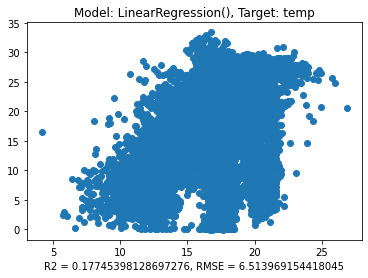

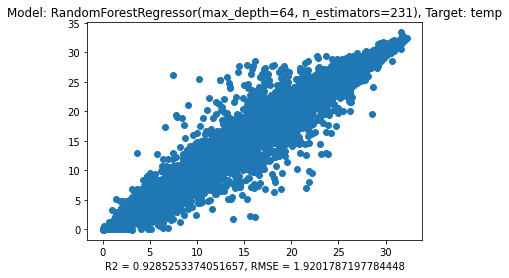

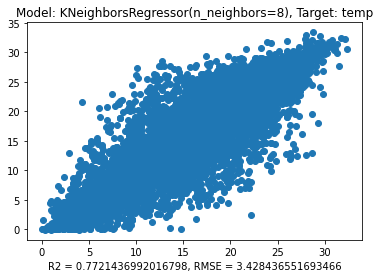

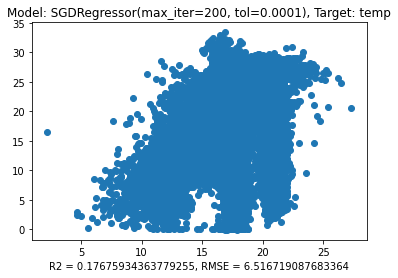

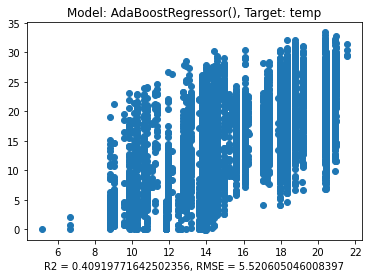

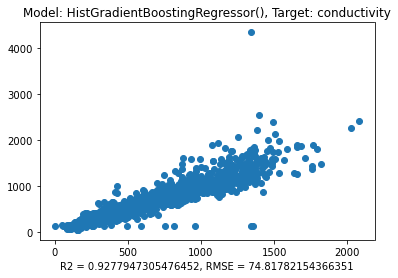

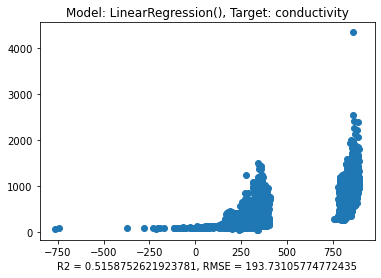

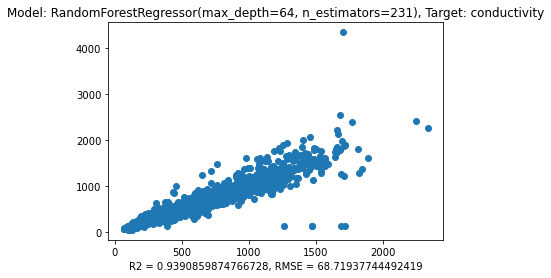

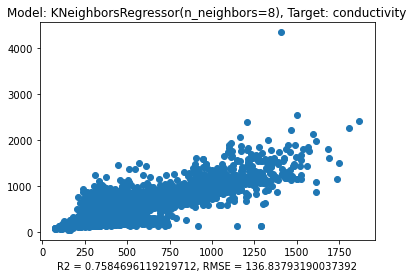

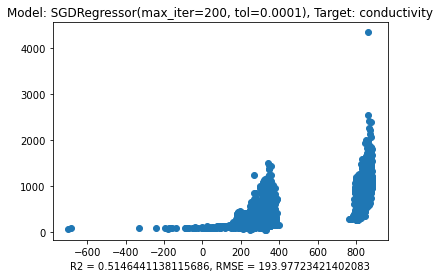

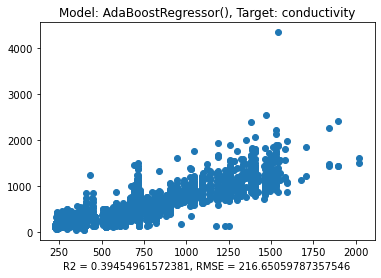

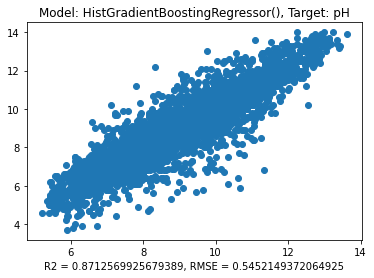

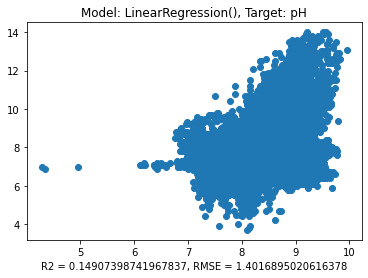

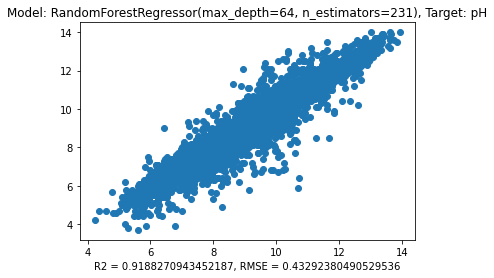

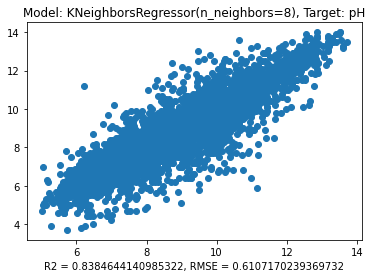

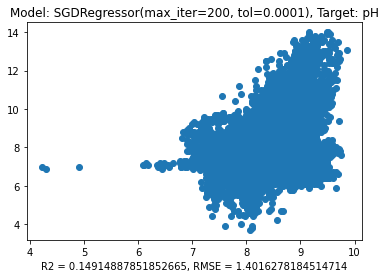

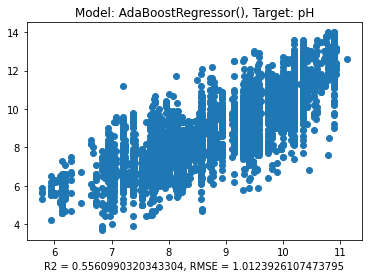

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.svm import SVC
#Best params for RFR from hyperparameter training: 'rf_n_estimators': 231, 'rf_max_depth': 64, 'rf_max_samples': 0.993
model_list=[HistGradientBoostingRegressor(),LinearRegression(),RandomForestRegressor(max_depth=64, n_estimators = 231)
            ,KNeighborsRegressor(n_neighbors=8),SGDRegressor(max_iter=200, tol=1e-4)
            ,AdaBoostRegressor()]

for j in range(1,6):
    if j == 0:
        x=arr_final[:,1:].astype(float)
        y=arr_final[:,0].astype(float)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    else:
        x=np.concatenate((arr_final[:,:j].astype(float),arr_final[:,j+1:].astype(float)),axis=1)
        y=arr_final[:,j].astype(float)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    count = 0
    for i in model_list:
        regr = make_pipeline(StandardScaler(),i)
        regr.fit(X_train, y_train)
        y_pred=regr.predict(X_test)
        plt.figure()
        plt.scatter(y_pred,y_test)
        r2=regr.score(X_test,y_test)
        rmse=mean_squared_error(y_pred,y_test, squared=False)
        plt.title('Model: '+str(model_list[count])+', Target: '+str(df.columns[j]))
        plt.xlabel('R2 = '+str(r2)+', RMSE = '+str(rmse))
        plt.show()
        count = count + 1

# Hyperparameter Training for Random Forest to Get R2 Scores of 0.93

In [6]:
#!pip install optuna
from sklearn.ensemble import RandomForestRegressor
import optuna
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
# For Optuna we need to define an objective function to maximize or minimize. In this case, we return r2 score
def objective(trial):
    #Shuffle the data otherwise cross-validation will give bad results (non-shuffled will have whole sites in the test data)
    np.random.shuffle(arr_final)
    #Scale the data
    arr=StandardScaler().fit_transform(arr_final)
    #Pick your target (discharge in this case)
    x=np.concatenate((arr[:,:2].astype(float),arr[:,3:].astype(float)),axis=1)
    y=arr[:,2].astype(float)
    #Define model parameters with the Optuna "trials" class
    #If the hyperparameter optimization runs too slow, you can lower the upper bounds of n_estimators and max_depth
    n_estimators = trial.suggest_int("rf_n_estimators", 40, 250, log=True)
    max_depth = trial.suggest_int("rf_max_depth", 8, 80, log=True)
    max_samples = trial.suggest_float("rf_max_samples", 0.4, 1)
    #Build model
    rf_model = RandomForestRegressor(
        max_depth = max_depth,
        max_samples = max_samples,
        n_estimators = n_estimators,
        random_state = 42)
    #Generate and return score
    score = cross_val_score(rf_model, x, y,  cv=3,scoring='r2').mean()
    return score

In [7]:
#Tell optuna if we want to maximise or minimize our score
study = optuna.create_study(direction = 'maximize')
#Feed optuna our objective function and number of trials
study.optimize(objective,n_trials = 30)
trial = study.best_trial
print ("Best Scores: ", trial.value)
print ("Best Params: ")
for key, value in trial.params.items():
    print ("  {}: {}".format(key,value))

[I 2023-03-01 10:24:47,886] A new study created in memory with name: no-name-e397d348-e160-4265-9c11-8ca006455260
[I 2023-03-01 10:25:10,417] Trial 0 finished with value: 0.9267415739003981 and parameters: {'rf_n_estimators': 99, 'rf_max_depth': 21, 'rf_max_samples': 0.9198018533736223}. Best is trial 0 with value: 0.9267415739003981.
[I 2023-03-01 10:25:21,909] Trial 1 finished with value: 0.9193747593298154 and parameters: {'rf_n_estimators': 50, 'rf_max_depth': 40, 'rf_max_samples': 0.7914633689135331}. Best is trial 0 with value: 0.9267415739003981.
[I 2023-03-01 10:25:32,469] Trial 2 finished with value: 0.9210771519949111 and parameters: {'rf_n_estimators': 43, 'rf_max_depth': 54, 'rf_max_samples': 0.8845194498395399}. Best is trial 0 with value: 0.9267415739003981.
[I 2023-03-01 10:25:44,697] Trial 3 finished with value: 0.9220517842782531 and parameters: {'rf_n_estimators': 55, 'rf_max_depth': 20, 'rf_max_samples': 0.9310933533410444}. Best is trial 0 with value: 0.926741573900

Best Scores:  0.9298502190633969
Best Params: 
  rf_n_estimators: 231
  rf_max_depth: 64
  rf_max_samples: 0.9930147206542437
